
# End-to-End Valuation — From Monthly Forwards to Fixed Price (One Asset)

This notebook starts from **monthly Peak/Off-Peak forwards** and produces :
- Build **hourly hub forward curve (HPFC)** from monthly forwards
- Add **basis** (hub↔node) and **DA–RT spread** structure from history
- Generate **hourly simulations** for RT/DA at hub & node
- Bootstrap **generation** from history
- Solve **4 fixed prices** (RT/DA × Hub/Node) at **P75** and show sensitivity (P50/P90)
- Plot **merchant vs fixed** and show a **price breakdown** waterfall


In [1]:

import yaml
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from src.data.loader import load_data
from src.features.calendar import make_calendar_index
from src.models.shape import hub_hourly_shape
from src.models.price import (
    shape_monthly_to_hourly,
    basis_stats,
    da_spread_stats,
    simulate_prices
)
from src.models.volume import bootstrap_generation
from src.pricing.solve_price import (
    solve_product_prices,
    expected_generation_monthly,
    compute_price_breakdown,
    solve_prices_for_levels,
)

CONFIG_PATH = "configs/project.yaml"
ASSET_NAME  = "Wind_A"
MARKET      = "ERCOT"
SEED        = 42
SCENARIOS   = 100
P_LEVEL     = 0.75
P_GRID      = [0.50, 0.75, 0.90]

cfg = yaml.safe_load(open(CONFIG_PATH, "r"))
start_year = cfg["start_year"]
end_year   = cfg["end_year"]
neg_rule   = cfg.get("negative_price_rule", "include")


In [2]:

hist_all, fwd_all = load_data(cfg)
hist = hist_all[hist_all['market'] == MARKET].copy()
hist_asset = hist_all[(hist_all['market']==MARKET) & (hist_all['asset']==ASSET_NAME)].copy()

print("Historical rows (market):", len(hist))
print("Historical rows (asset):", len(hist_asset))
display(hist_asset.head(3))

for col in ['gen_mwh','rt_hub','rt_node','da_hub','da_node']:
    hist[col] = pd.to_numeric(hist[col], errors='coerce')
    hist_asset[col] = pd.to_numeric(hist_asset[col], errors='coerce')


c:\Users\mpanah01\Documents\GitHub\rec_hedge_pricer\src\data\loader.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
c:\Users\mpanah01\Documents\GitHub\rec_hedge_pricer\src\data\loader.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


Historical rows (market): 26304
Historical rows (asset): 26304


c:\Users\mpanah01\Documents\GitHub\rec_hedge_pricer\src\data\loader.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
c:\Users\mpanah01\Documents\GitHub\rec_hedge_pricer\src\data\loader.py:93: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = parsed.fillna(pd.to_datetime(s, errors="coerce"))
c:\Users\mpanah01\Documents\GitHub\rec_hedge_pricer\src\data\loader.py:93: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = parsed.fillna(pd.to_datetime(s, errors="coerce"))
c:\Users\mpanah01\Documents\GitHub\rec_hedge_pricer\src\dat

,date,he,peak_flag,gen_mwh,rt_node,rt_hub,da_node,da_hub,asset,market
0,2022-01-01,1,OP,36.8,0.74,56.43,5.20,30.17,Wind_A,ERCOT
1,2022-01-01,2,OP,17.0,3.78,29.24,1.54,22.08,Wind_A,ERCOT
2,2022-01-01,3,OP,14.6,4.00,22.15,1.83,19.97,Wind_A,ERCOT


In [3]:

cal = make_calendar_index(start_year, end_year)
cal.head()


,ts,date,he,month,weekday
0,2026-01-01 00:00:00,2026-01-01,1,2026-01-01,3
1,2026-01-01 01:00:00,2026-01-01,2,2026-01-01,3
2,2026-01-01 02:00:00,2026-01-01,3,2026-01-01,3
3,2026-01-01 03:00:00,2026-01-01,4,2026-01-01,3
4,2026-01-01 04:00:00,2026-01-01,5,2026-01-01,3


### Hourly Shape, Basis, and DA–RT Spreads 

We extract three building blocks from historical data `hist` to drive the forward-consistent hourly curve and simulations.

#### 1) Hourly hub shape — `hub_hourly_shape(hist)`
For month-of-year $m_o \in \{1,\dots,12\}$ and hour-ending $h \in \{1,\dots,24\}$, define the **hourly shape**:
$$
S_{m_o,h}
= \frac{\mathbb{E}\!\left[\text{RT}^{\text{hub}}_{\tau}\mid \text{mon}(\tau)=m_o,\ \text{HE}(\tau)=h\right]}
        {\mathbb{E}\!\left[\text{RT}^{\text{hub}}_{\tau}\mid \text{mon}(\tau)=m_o\right]}.
$$
- Numerator: average historical **hub RT** at $(m_o,h)$  
- Denominator: historical monthly average for the same $m_o$  
- Used to **shape monthly Peak/Off-Peak forwards into hourly** while preserving bucket means.

**Typical columns:** `market, mon, hour, shape`.


#### 2) Real-time hub↔node basis — `basis_stats(hist, price_col_hub='rt_hub', price_col_node='rt_node')`
Define the **RT basis** at hour $\tau$:
$$
\text{Basis}^{\text{RT}}_{\tau} = \text{RT}^{\text{hub}}_{\tau} - \text{RT}^{\text{node}}_{\tau}.
$$
Aggregate by $(\text{market}, m_o, h)$:
$$
B_{m_o,h}=\mathbb{E}\!\left[\text{Basis}^{\text{RT}}_{\tau}\mid \text{mon}(\tau)=m_o,\ \text{HE}(\tau)=h\right],\qquad
\sigma^{B}_{m_o,h}=\operatorname{Std}\!\left[\text{Basis}^{\text{RT}}_{\tau}\mid \cdot\right].
$$
- $B_{m_o,h}$: expected hub→node conversion in RT for that seasonal hour  
- $\sigma^{B}_{m_o,h}$: basis volatility (used to simulate node prices)

**Typical columns:** `market, mon, hour, mean, std`.


#### 3) Day-ahead minus Real-time spreads — `da_spread_stats(hist, level='hub'|'node')`
For **hub**:
$$
\text{Spr}^{\text{hub}}_{\tau}=\text{DA}^{\text{hub}}_{\tau}-\text{RT}^{\text{hub}}_{\tau}.
$$
For **node**:
$$
\text{Spr}^{\text{node}}_{\tau}=\text{DA}^{\text{node}}_{\tau}-\text{RT}^{\text{node}}_{\tau}.
$$
Aggregate by $(\text{market}, m_o, h)$:
$$
S^{\text{hub}}_{m_o,h}=\mathbb{E}\!\left[\text{Spr}^{\text{hub}}_{\tau}\mid \cdot\right],\quad
\sigma^{\text{hub}}_{m_o,h}=\operatorname{Std}\!\left[\text{Spr}^{\text{hub}}_{\tau}\mid \cdot\right],
$$
$$
S^{\text{node}}_{m_o,h}=\mathbb{E}\!\left[\text{Spr}^{\text{node}}_{\tau}\mid \cdot\right],\quad
\sigma^{\text{node}}_{m_o,h}=\operatorname{Std}\!\left[\text{Spr}^{\text{node}}_{\tau}\mid \cdot\right].
$$
- Expected DA uplift/discount vs RT and its volatility at hub/node by seasonal hour

**Typical columns:** `market, mon, hour, mean, std`.




In [4]:

shape_tbl = hub_hourly_shape(hist)
bs_rt   = basis_stats(hist, price_col_hub='rt_hub', price_col_node='rt_node')
spr_hub = da_spread_stats(hist, level='hub')
spr_node= da_spread_stats(hist, level='node')

print("shape rows:", len(shape_tbl), " | basis rows:", len(bs_rt), " | spread rows:", len(spr_hub), len(spr_node))
display(bs_rt.head(3))


shape rows: 288  | basis rows: 288  | spread rows: 288 288


,market,mon,hour,mean,std
0,ERCOT,1,1,4.404946,12.626344
1,ERCOT,1,2,4.476667,14.150294
2,ERCOT,1,3,4.376022,14.212149


Hourly hub forward rows (market): 43824


,ts,market,hub_forward_hourly
0,2026-01-01 00:00:00,ERCOT,50.675117
1,2026-01-01 01:00:00,ERCOT,46.473503
2,2026-01-01 02:00:00,ERCOT,47.820409
3,2026-01-01 03:00:00,ERCOT,51.180059
4,2026-01-01 04:00:00,ERCOT,54.314693


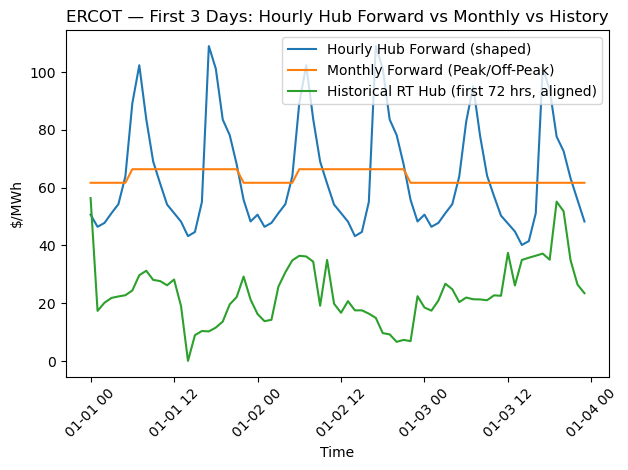

In [5]:

hh_all = shape_monthly_to_hourly(fwd_all, shape_tbl, cal)
hh = hh_all[hh_all['market']==MARKET].copy().sort_values('ts').reset_index(drop=True)

print("Hourly hub forward rows (market):", len(hh))
display(hh.head(5))

import numpy as np
hh_plot = hh.copy()
hh_plot['ts'] = pd.to_datetime(hh_plot['ts'])
t0 = hh_plot['ts'].min()
t1 = t0 + pd.Timedelta(days=3)
hh_3d = hh_plot[(hh_plot['ts']>=t0) & (hh_plot['ts']<t1)].copy().sort_values('ts')
he = hh_3d['ts'].dt.hour + 1
is_peak = (hh_3d['ts'].dt.weekday <= 4) & (he.between(7,22))

m0 = pd.Timestamp(hh_3d['ts'].iloc[0]).to_period('M').to_timestamp()
fwd_row = fwd_all[(fwd_all['market']==MARKET) & (fwd_all['month']==m0)]
if fwd_row.empty:
    print("WARNING: No fwd row for", MARKET, m0)
peak_val, off_val = float(fwd_row['peak'].iloc[0]), float(fwd_row['offpeak'].iloc[0])
fwd_bucket_series = np.where(is_peak, peak_val, off_val)

hist_mkt = hist.sort_values('date')
hist_72 = hist_mkt[['date','rt_hub']].iloc[:72].copy()
hist_72['ts'] = hh_3d['ts'].values

plt.figure()
plt.plot(hh_3d['ts'], hh_3d['hub_forward_hourly'], label='Hourly Hub Forward (shaped)')
plt.plot(hh_3d['ts'], fwd_bucket_series, label='Monthly Forward (Peak/Off-Peak)')
plt.plot(hist_72['ts'], hist_72['rt_hub'], label='Historical RT Hub (first 72 hrs, aligned)')
plt.title(f'{MARKET} — First 3 Days: Hourly Hub Forward vs Monthly vs History')
plt.xlabel('Time'); plt.ylabel('$/MWh'); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()


### Hourly Price Simulation and RT Mean Plot 

We generate **hourly price scenarios** for the valuation horizon using the forward-shaped hub curve and historical basis/DA–RT statistics.

#### 1) Simulate RT/DA at hub and node — `simulate_prices(...)`

For each hour $t$ (with month-of-year $m_o$ and hour-ending $h$) and scenario $s$:

- **Hub RT** is anchored to the hourly hub forward (HPFC):
  $$
  \text{RT}^{\text{hub}}_{t,s} \;=\; H_t
  $$

- **RT basis** (hub→node) is stochastic with seasonal-hour mean/vol:
  $$
  \text{Basis}^{\text{RT}}_{t,s}
  \;=\; B_{m_o,h} \;+\; \sigma^B_{m_o,h}\,\epsilon^B_{t,s},
  \qquad \epsilon^B_{t,s}\sim \mathcal{N}(0,1)
  $$

- **Node RT** subtracts that basis from hub RT:
  $$
  \text{RT}^{\text{node}}_{t,s} \;=\; \text{RT}^{\text{hub}}_{t,s} \;-\; \text{Basis}^{\text{RT}}_{t,s}
  $$

- **DA–RT spreads** at hub/node are also stochastic with seasonal-hour mean/vol:
  $$
  \text{Spr}^{\text{hub}}_{t,s}
  \;=\; S^{\text{hub}}_{m_o,h} \;+\; \sigma^{\text{hub}}_{m_o,h}\,\epsilon^{\text{hub}}_{t,s},
  \qquad \epsilon^{\text{hub}}_{t,s}\sim \mathcal{N}(0,1)
  $$
  $$
  \text{Spr}^{\text{node}}_{t,s}
  \;=\; S^{\text{node}}_{m_o,h} \;+\; \sigma^{\text{node}}_{m_o,h}\,\epsilon^{\text{node}}_{t,s},
  \qquad \epsilon^{\text{node}}_{t,s}\sim \mathcal{N}(0,1)
  $$

- **DA prices** are RT plus the DA–RT spread:
  $$
  \text{DA}^{\text{hub}}_{t,s} \;=\; \text{RT}^{\text{hub}}_{t,s} \;+\; \text{Spr}^{\text{hub}}_{t,s},
  \qquad
  \text{DA}^{\text{node}}_{t,s} \;=\; \text{RT}^{\text{node}}_{t,s} \;+\; \text{Spr}^{\text{node}}_{t,s}
  $$

Inputs:
- `hh` provides $H_t$ (hourly hub forward).
- `bs_rt` provides $B_{m_o,h}, \sigma^B_{m_o,h}$.
- `spr_hub`, `spr_node` provide $S^{\text{hub}}_{m_o,h}, \sigma^{\text{hub}}_{m_o,h}$ and $S^{\text{node}}_{m_o,h}, \sigma^{\text{node}}_{m_o,h}$.

The result `sims_all` contains hourly paths for `hub_rt`, `node_rt`, `hub_da`, `node_da` for all scenarios.

```python
sims_all = simulate_prices(hh, bs_rt, spr_hub, spr_node, n_scenarios=SCENARIOS, seed=SEED)
sims = sims_all[sims_all['market']==MARKET].copy()
display(sims.head(3))


,s,ts,market,hub_rt,node_rt,hub_da,node_da
0,0,2026-01-01 00:00:00,ERCOT,50.675117,42.422708,17.400523,40.642077
1,0,2026-01-01 01:00:00,ERCOT,46.473503,56.712918,32.492641,51.216457
2,0,2026-01-01 02:00:00,ERCOT,47.820409,32.778863,64.244722,29.603394


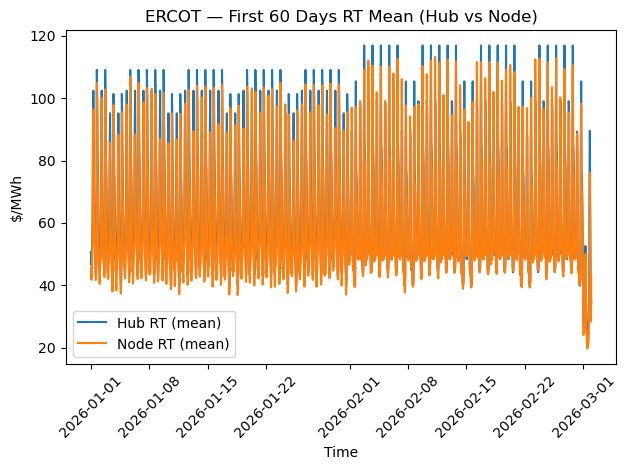

In [6]:

sims_all = simulate_prices(hh, bs_rt, spr_hub, spr_node, n_scenarios=SCENARIOS, seed=SEED)
sims = sims_all[sims_all['market']==MARKET].copy()
display(sims.head(3))

summary = sims.groupby('ts')[['hub_rt','node_rt']].mean().reset_index()
first = summary.iloc[:24*60]
plt.figure()
plt.plot(first['ts'], first['hub_rt'], label='Hub RT (mean)')
plt.plot(first['ts'], first['node_rt'], label='Node RT (mean)')
plt.title(f'{MARKET} — First 60 Days RT Mean (Hub vs Node)')
plt.xlabel('Time'); plt.ylabel('$/MWh'); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


In [7]:
# --- 1) Build volume samples by month-of-year & HE 1..24 ---
hist_filt = hist_all[(hist_all['asset'] == ASSET_NAME) & (hist_all['market'] == MARKET)].copy()
hist_filt['gen_mwh'] = pd.to_numeric(hist_filt['gen_mwh'], errors='coerce').fillna(0.0)

hist_filt['mon']  = hist_filt['date'].dt.month               # 1..12
hist_filt['hour'] = hist_filt['he']                           # HE 1..24 (ensure your 'he' is 1..24)

vol_tbl = (hist_filt
           .groupby(['asset','market','mon','hour'])['gen_mwh']
           .apply(list).reset_index(name='samples'))

print("Non-empty sample buckets:", (vol_tbl['samples'].apply(lambda x: isinstance(x, list) and len(x) > 0)).sum())

# --- 2) Calendar keyed the same way (mon + HE) ---
cal_mon = cal.copy()
cal_mon['ts']   = pd.to_datetime(cal_mon['ts'])
cal_mon['mon']  = cal_mon['ts'].dt.month
cal_mon['hour'] = cal_mon['ts'].dt.hour + 1      # HE 1..24

# --- 3) Bootstrap using month-of-year + HE buckets ---
rng = np.random.default_rng(SEED)

base = (cal_mon.assign(_k=1)
        .merge(vol_tbl.assign(_k=1), on='_k', how='left')
        .drop(columns=['_k']))

# Keep only this asset/market rows (vol_tbl has those identifiers)
base = base[(base['asset'] == ASSET_NAME) & (base['market'] == MARKET)]

# Match diagnostics: what share of hours have a sample list available?
match_rate = 1.0 - base['samples'].isna().mean()
print(f"Generation bucket match rate: {match_rate:.1%}")




Non-empty sample buckets: 288
Generation bucket match rate: 100.0%


### Bootstrapped Hourly Generation Scenarios 

We create empirical, scenario-based **generation** paths by sampling historical output in matching **seasonal-hour** buckets.

#### 1) Build historical volume table — `build_volume_table(...)`
For each asset/market, we collect historical generation into buckets keyed by **month-of-year** and **hour-ending (HE 1..24)**.

- Keys: $m_o \in \{1,\dots,12\}$ and $h \in \{1,\dots,24\}$
- Bucket definition (plain text):
  $\;\text{Bucket}(m_o,h)=\{\text{gen\_mwh}_\tau:\ \text{mon}(\tau)=m_o,\ \text{HE}(\tau)=h\}$
- Stored as a NumPy array per bucket:
  $\; \text{samples}[m_o,h] = \big(\text{gen\_mwh}^1,\dots,\text{gen\_mwh}^{N_{m_o,h}}\big)$

This preserves the **empirical distribution** of generation for each seasonal hour.

**Code:**
```python
vol_tbl = build_volume_table(hist_all, ASSET_NAME, MARKET)


In [8]:
from src.models.volume import build_volume_table, bootstrap_generation

vol_tbl = build_volume_table(hist_all, ASSET_NAME, MARKET)
rng = np.random.default_rng(SEED)
gen = bootstrap_generation(cal, vol_tbl, n_scenarios=SCENARIOS, rng=rng)

print("gen rows:", len(gen), "| mean:", float(gen['gen_mwh'].mean()))
display(gen.head(3))


gen rows: 4382400 | mean: 20.729087829589844


,s,ts,asset,market,gen_mwh
0,0,2026-01-01 00:00:00,Wind_A,ERCOT,34.099998
1,0,2026-01-01 01:00:00,Wind_A,ERCOT,24.100000
2,0,2026-01-01 02:00:00,Wind_A,ERCOT,29.500000


In [9]:

eg = expected_generation_monthly(gen)
eg_asset = eg[eg['asset']==ASSET_NAME].copy()
display(eg_asset.head(6))

Path('results').mkdir(exist_ok=True)
eg_asset.to_csv('results/expected_generation_asset.csv', index=False)


,asset,month,bucket,expected_mwh
0,Wind_A,2026-01-01,Off-Peak,18.138584
1,Wind_A,2026-01-01,Peak,19.501377
2,Wind_A,2026-02-01,Off-Peak,16.322048
3,Wind_A,2026-02-01,Peak,18.180319
4,Wind_A,2026-03-01,Off-Peak,21.078482
5,Wind_A,2026-03-01,Peak,22.480635




We compute the **flat fixed price** $P^*$ for each product so that, across scenarios, the hedge is at least as good as merchant with probability $p$ (e.g., $p=0.75$ for **P75**).

#### Products
- `RT_HUB`: sell as-generated at **node RT** vs fixed at **hub** reference  
- `RT_NODE`: sell as-generated at **node RT** vs fixed at **node** reference  
- `DA_HUB`: sell as-generated at **node RT** vs fixed at **hub DA** reference  
- `DA_NODE`: sell as-generated at **node RT** vs fixed at **node DA** reference

> Rationale: Merchant value uses **as-generated node RT** cashflow; the fixed product settles vs a reference price (hub/node; RT/DA).

#### Decision Rule (per product)
For hour $t$ and scenario $s$, let volume be $G_{t,s}$ (bootstrapped generation).  
- Merchant cashflow (per scenario):  
  $\mathrm{Merch}_s = \sum_t G_{t,s}\cdot \mathrm{RT}^{\text{node}}_{t,s}$
- Hedge cashflow (per scenario), with reference price $R_{t,s}$ matching the selected product:  
  $\mathrm{Hedge}_s(P) = \sum_t (P - R_{t,s})\cdot \tilde{G}_{t,s}$

Negative-price rule:
- If `negative_rule = 'zero'`, use $\tilde{G}_{t,s} = 0$ whenever $R_{t,s} < 0$; else $\tilde{G}_{t,s} = G_{t,s}$.

**Target fixed price** $P^*$ solves:

$$
\operatorname{Quantile}_{1-p}\!\left(\mathrm{Hedge}_s(P^*) - \mathrm{Merch}_s\right) = 0
$$
i.e., the $(1-p)$ tail of (hedge − merchant) is zero → at least a $p$ fraction of scenarios prefer the hedge.



In [10]:

products = ['RT_HUB','RT_NODE','DA_HUB','DA_NODE']
prices_p75 = solve_product_prices(sims, gen, products, p_level=P_LEVEL, negative_rule=neg_rule)
prices_p75 = prices_p75[prices_p75['asset']==ASSET_NAME].copy().reset_index(drop=True)
display(prices_p75)


prices_grid = solve_prices_for_levels(sims, gen, products, P_GRID, negative_rule=neg_rule)
prices_grid = prices_grid[prices_grid['asset']==ASSET_NAME].copy().reset_index(drop=True)
display(prices_grid.head(12))

prices_p75.to_csv('results/fixed_prices_asset_p75.csv', index=False)
prices_grid.to_csv('results/fixed_prices_asset_pgrid.csv', index=False)


,asset,product,p_level,negative_rule,fixed_price
0,Wind_A,RT_HUB,0.75,include,105.939238
1,Wind_A,RT_NODE,0.75,include,97.168064
2,Wind_A,DA_HUB,0.75,include,113.497165
3,Wind_A,DA_NODE,0.75,include,104.605653


,asset,product,p_level,negative_rule,fixed_price
0,Wind_A,RT_HUB,0.50,include,105.701193
1,Wind_A,RT_NODE,0.50,include,96.753428
2,Wind_A,DA_HUB,0.50,include,113.228406
3,Wind_A,DA_NODE,0.50,include,104.087377
4,Wind_A,RT_HUB,0.75,include,105.939238
5,Wind_A,RT_NODE,0.75,include,97.168064
6,Wind_A,DA_HUB,0.75,include,113.497165
7,Wind_A,DA_NODE,0.75,include,104.605653
8,Wind_A,RT_HUB,0.90,include,106.071528
9,Wind_A,RT_NODE,0.90,include,97.479477


In [11]:

breakdown_all = compute_price_breakdown(
    hourly_hub_fwd=hh,
    basis_mean_rt=bs_rt[['market','mon','hour','mean']],
    da_spr_mean_hub=spr_hub[['market','mon','hour','mean']],
    da_spr_mean_node=spr_node[['market','mon','hour','mean']],
    sims=sims,
    gen_df=gen,
    products=products,
    p_level=P_LEVEL
)
bk = breakdown_all[breakdown_all['asset']==ASSET_NAME].copy().reset_index(drop=True)
display(bk)
bk.to_csv('results/price_breakdown_asset.csv', index=False)


,asset,product,p_level,hub_mean,basis_mean,da_spr_hub_mean,da_spr_node_mean,expected_ref_price,fixed_price,risk_premium
0,Wind_A,RT_HUB,0.75,57.295065,8.964357,7.452024,7.181564,57.295065,105.939238,48.644174
1,Wind_A,RT_NODE,0.75,57.295065,8.964357,7.452024,7.181564,48.330707,106.276688,57.945981
2,Wind_A,DA_HUB,0.75,57.295065,8.964357,7.452024,7.181564,64.747089,124.084474,59.337385
3,Wind_A,DA_NODE,0.75,57.295065,8.964357,7.452024,7.181564,55.512271,124.533521,69.021249


C:\Users\mpanah01\AppData\Local\Temp\ipykernel_26232\778916926.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals = [float(prices_p75[prices_p75['product']==p]['fixed_price']) for p in products]


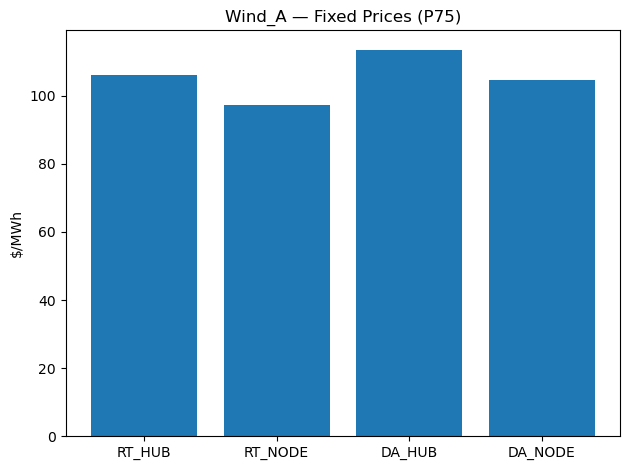

In [12]:

plt.figure()
x = np.arange(len(products))
vals = [float(prices_p75[prices_p75['product']==p]['fixed_price']) for p in products]
plt.bar(x, vals)
plt.xticks(x, products); plt.ylabel('$/MWh'); plt.title(f'{ASSET_NAME} — Fixed Prices (P75)')
plt.tight_layout(); plt.show()


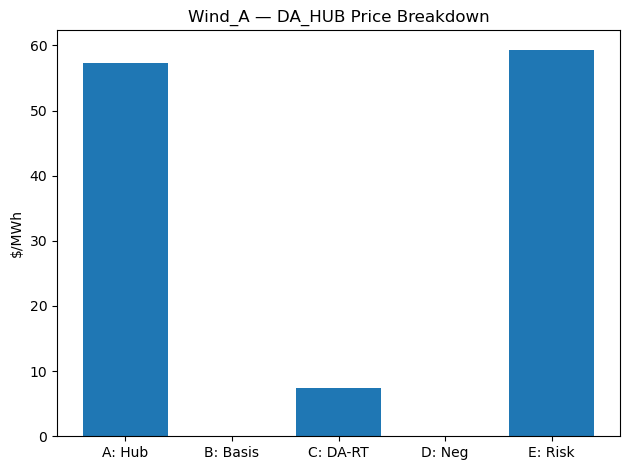

In [17]:
row = bk.iloc[2]  # choose the product row you want to plot

# pick mapping by product
prod = row['product']
if   prod == 'RT_HUB':
    A = float(row['hub_mean'])
    B = 0.0
    C = 0.0
elif prod == 'RT_NODE':
    A = float(row['hub_mean'])
    B = float(-row['basis_mean'])
    C = 0.0
elif prod == 'DA_HUB':
    A = float(row['hub_mean'])
    B = 0.0
    C = float(row['da_spr_hub_mean'])
elif prod == 'DA_NODE':
    A = float(row['hub_mean'])
    B = float(-row['basis_mean'])
    C = float(row['da_spr_node_mean'])
else:
    raise ValueError(f"Unknown product {prod}")

D = 0.0  # we didn't compute negative-rule effect separately here
E = float(row['risk_premium'])  # includes neg-rule + volatility residual

steps  = ['A_hub_capture','B_basis','C_da_rt','D_neg_rule','E_risk']
labels = ['A: Hub','B: Basis','C: DA-RT','D: Neg','E: Risk']
values = [A,B,C,D,E]

import matplotlib.pyplot as plt
plt.figure()
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels, rotation=0)
plt.title(f"{row['asset']} — {row['product']} Price Breakdown")
plt.ylabel("$/MWh")
plt.tight_layout(); plt.show()


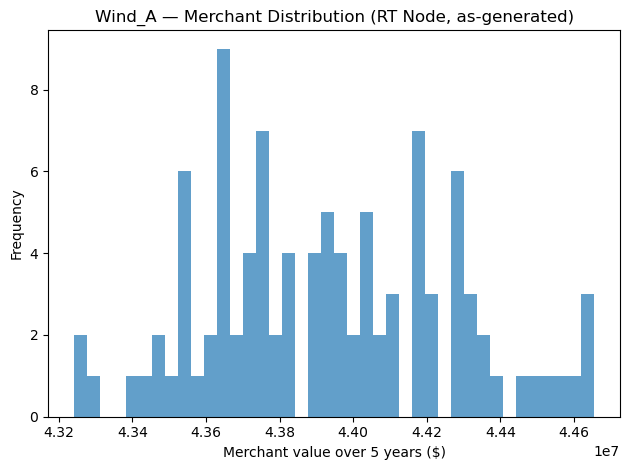

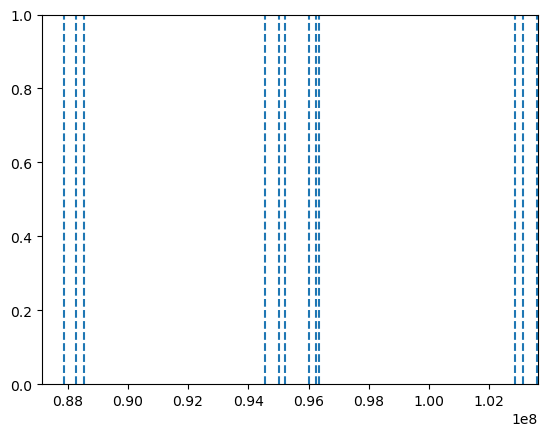

In [18]:

dfm = gen.merge(sims, on=['s','ts','market'])
dfm['merchant_rt_node'] = dfm['gen_mwh'] * dfm['node_rt']
agg = dfm.groupby(['s'])['merchant_rt_node'].sum().reset_index()

plt.figure()
plt.hist(agg['merchant_rt_node'], bins=40, alpha=0.7)
plt.xlabel('Merchant value over 5 years ($)'); plt.ylabel('Frequency')
plt.title(f'{ASSET_NAME} — Merchant Distribution (RT Node, as-generated)')
plt.tight_layout(); plt.show()

exp_mwh = gen.groupby('s')['gen_mwh'].sum().mean()
for p in [0.50, 0.75, 0.90]:
    for prod in products:
        P_star = float(prices_grid[(prices_grid['p_level']==p) & (prices_grid['product']==prod)]['fixed_price'].iloc[0])
        plt.axvline(P_star * exp_mwh, linestyle='--')
plt.show()
